In [2]:
# import ROOT
# import numpy as np
# import os
# import matplotlib.pyplot as plt
# from array import array
# from scipy.optimize import minimize_scalar
# import math

# def plot_yield_scaler(run, current, correction):
#     filename = f"/lustre24/expphy/cache/hallc/c-nps/analysis/pass1/replays/skim/nps_hms_skim_{run}_1_-1.root"
    
#     if not os.path.isfile(filename):
#         print(f"Error: File not found for run {run}")
#         return -1

#     data_file = ROOT.TFile.Open(filename)
#     scaler_tree = data_file.Get("TSH")
#     t_tree = data_file.Get("T")
#     if not scaler_tree:
#         print(f"Error: Couldn't find scaler tree 'TSH' in file {filename}")
#         return -1

#     # Define ROOT-compatible arrays
#     H_BCM4A_scalerCharge = array('d', [0.])
#     H_BCM4A_scalerCurrent = array('d', [0.])
#     H_BCM4A_scaler = array('d', [0.])
#     H_EDTM_scaler = array('d', [0.])
#     H_hTRIG4_scaler = array('d', [0.])
#     H_1MHz_scalerTime = array('d', [0.])
#     H_cal_etottracknorm = array('d', [0.])

#     scaler_tree.SetBranchAddress("H.BCM4A.scalerCharge", H_BCM4A_scalerCharge)
#     scaler_tree.SetBranchAddress("H.BCM4A.scalerCurrent", H_BCM4A_scalerCurrent)
#     scaler_tree.SetBranchAddress("H.BCM4A.scaler", H_BCM4A_scaler)
#     scaler_tree.SetBranchAddress("H.EDTM.scaler", H_EDTM_scaler)
#     scaler_tree.SetBranchAddress("H.hTRIG4.scaler", H_hTRIG4_scaler)
#     scaler_tree.SetBranchAddress("H.1MHz.scalerTime", H_1MHz_scalerTime)
#     t_tree.SetBranchAddress("H.cal.etottracknorm", H_cal_etottracknorm)

#     nentries = scaler_tree.GetEntries()
#     if nentries < 2:
#         print(f"Error: Not enough scaler entries in run {run}")
#         return -1

#     accumulated_charge = 0
#     accumulated_edtm = 0
#     accumulated_hTRIG4 = 0
#     prev_time = 0
#     prev_EDTM = 0
#     prev_hTRIG4 = 0
#     prev_BCM4A_scaler = 0

#     for i in range(nentries - 1):
#         scaler_tree.GetEntry(i)

#         if i == 0:
#             prev_time = H_1MHz_scalerTime[0]
#             prev_EDTM = H_EDTM_scaler[0]
#             prev_hTRIG4 = H_hTRIG4_scaler[0]
#             prev_BCM4A_scaler = H_BCM4A_scaler[0]
#             continue

#         delta_time = H_1MHz_scalerTime[0] - prev_time
#         delta_trig4 = H_hTRIG4_scaler[0] - prev_hTRIG4

#         if abs(H_BCM4A_scalerCurrent[0] - current) < 1.0 :

#             rate = ((H_BCM4A_scaler[0] - prev_BCM4A_scaler) / (H_1MHz_scalerTime[0] - prev_time))

#             # corrected_current = H_BCM4A_scalerCurrent[0] + correction*math.sqrt(rate) # form of corrected current from (2muA/sqrt(rate))
#             corrected_current = H_BCM4A_scalerCurrent[0] + correction # form of corrected current from KaonLT
            
#             accumulated_charge += corrected_current * delta_time
#             # print('current: ', H_BCM4A_scalerCurrent[0])
#             # print(H_EDTM_scaler[0] - prev_EDTM)
#             accumulated_edtm += (H_EDTM_scaler[0] - prev_EDTM)
#             accumulated_hTRIG4 += delta_trig4

#         prev_time = H_1MHz_scalerTime[0]
#         prev_EDTM = H_EDTM_scaler[0]
#         prev_hTRIG4 = H_hTRIG4_scaler[0]
#         prev_BCM4A_scaler = H_BCM4A_scaler[0]

#     # beam_on_percent_edtm = (scaler_edtm_total/scaler_edtm_no_cut)
#     # beam_on_percent_trig_accp = (trig_accp_total/trig_accp_no_cut)
#     # entries_t = t_tree.GetEntries()

#     # for i in range(nentries_t):
#     #     t_tree.GetEntry(i)

#     #     if T_hms_hEDTM_tdcTimeRaw[0] != 0:
#     #         t_edtm_accepted += 1

#     #     if T_hms_hTRIG4_tdcTimeRaw[0] != 0:
#     #         t_hTRIG4_all_accepted += 1

#     #     if T_hms_hTRIG4_tdcTimeRaw[0] !=0 and T_hms_hEDTM_tdcTimeRaw[0] == 0:
#     #         t_hTRIG4_phy_accepted += 1

#     data_file.Close()
    
#     if accumulated_charge <= 0:
#         print(f"Warning: Accumulated charge is zero or negative for run {run}")
#         print(accumulated_charge)
#         return -1

#     yield_norm = (accumulated_hTRIG4 - accumulated_edtm) / accumulated_charge
#     # yield_norm = (accumulated_hTRIG4) / accumulated_charge
#     # yield_norm = (t_hTRIG4_phy_accepted*beam_on_percent_trig_accp)/accumulated_charge
#     return yield_norm



# # Define cost function: we want normalized yields to be as close to 1 as possible
# def cost_function(correction, runs, currents):
#     yields = []
#     for run, current in zip(runs, currents):
#         y = plot_yield_scaler(run, current, correction)
#         if y > 0:
#             yields.append(y)
#         else:
#             return 1e6  # penalize invalid values

#     if len(yields) == 0:
#         return 1e6

#     yields = np.array(yields)
#     normalized_yields = yields / np.min(yields)

#     # Cost: sum of squared deviations from 1
#     cost = np.sum((normalized_yields - 1) ** 2)
#     return cost



import ROOT
import numpy as np
import os
import matplotlib.pyplot as plt
from array import array
from scipy.optimize import minimize_scalar
from pathlib import Path
import pandas as pd

livetime_df = pd.read_csv("/w/hallc-scshelf2102/nps/singhav/nps_analysis/luminosity_analysis/livetime_results.csv")

# Define the directory containing segment files
directory = Path("/lustre24/expphy/volatile/hallc/nps/singhav/ROOTfiles/luminosity_all")

def get_clta_livetime_tdc(run_number):
    row = livetime_df[livetime_df["run"] == run_number]
    if not row.empty:
        return row["CLTA_livetime_tdc"].values[0]
    else:
        print(f"Warning: Run {run_number} not found in livetime CSV.")
        return 1.0  # Return neutral factor if missing

def get_segment_files(run):
    """Returns all segment files for a given run."""
    return sorted(directory.glob(f"nps_hms_coin_{run}_*_1_-1.root"))

def plot_yield_scaler(run, current, ps_factor, correction):
    """Analyzes all segments for a run and returns scaler EDTM and triggered EDTM counts."""
    scaler_edtm_total = 0
    scaler_hTRIG4_total = 0
    scaler_hEL_REAL_total = 0
    trig_accp_total = 0
    trig_accp_no_cut = 0
    t_edtm_accepted = 0
    scaler_edtm_no_cut = 0
    t_hTRIG4_all_accepted = 0
    t_hTRIG4_all_accepted_untracked = 0
    t_hTRIG4_all_accepted_tracked = 0
    t_hTRIG4_phy_accepted = 0
   
    accumulated_charge = 0
    accumulated_edtm = 0
    accumulated_hTRIG4 = 0
    prev_EDTM = 0
    prev_accp = 0
    prev_hTRIG4 = 0
    prev_hEL_REAL = 0
    prev_time = 0
    prev_BCM4A_scaler = 0
    
    segment_files = get_segment_files(run)

    for fpath in segment_files:
        print(fpath)
        root_file = ROOT.TFile(str(fpath))
        tsh_tree = root_file.Get("TSH")
        t_tree = root_file.Get("T")

        if not tsh_tree or not t_tree:
            print(f"Skipping: Couldn't load TSH or T from {fpath.name}")
            continue

        # Define ROOT-compatible arrays
        H_BCM4A_scalerCharge = array('d', [0.])
        H_BCM4A_scalerCurrent = array('d', [0.])
        H_BCM4A_scaler = array('d', [0.])
        H_EDTM_scaler = array('d', [0.])
        H_hTRIG4_scaler = array('d', [0.])
        H_hL1ACCP_scaler = array('d', [0.])
        H_hEL_REAL_scaler = array('d', [0.])
        H_1MHz_scalerTime = array('d', [0.])

        T_hms_hEDTM_tdcTimeRaw = array('d', [0.])
        T_hms_hTRIG4_tdcTimeRaw = array('d', [0.])

        H_cer_npeSum = array('d', [0.])
        H_cal_etotnorm = array('d', [0.])
        H_cal_etottracknorm = array('d', [0.])
        H_gtr_dp = array('d', [0.])
        H_gtr_ok = array('d', [0.])
        H_react_ok = array('d', [0.])
        H_gtr_th = array('d', [0.])
        H_gtr_ph = array('d', [0.])

        # Disable all branches
        tsh_tree.SetBranchStatus("*", 0)
        t_tree.SetBranchStatus("*", 0)

        # Enable only the branches you use from TSH
        tsh_tree.SetBranchStatus("H.BCM4A.scalerCharge", 1)
        tsh_tree.SetBranchStatus("H.BCM4A.scalerCurrent", 1)
        tsh_tree.SetBranchStatus("H.BCM4A.scaler", 1)
        tsh_tree.SetBranchStatus("H.EDTM.scaler", 1)
        tsh_tree.SetBranchStatus("H.hTRIG4.scaler", 1)
        tsh_tree.SetBranchStatus("H.hL1ACCP.scaler", 1)
        tsh_tree.SetBranchStatus("H.hEL_REAL.scaler", 1)
        tsh_tree.SetBranchStatus("H.1MHz.scalerTime", 1)

        # Enable only the branches you use from T
        t_tree.SetBranchStatus("T.hms.hEDTM_tdcTimeRaw", 1)
        t_tree.SetBranchStatus("T.hms.hTRIG4_tdcTimeRaw", 1)
        t_tree.SetBranchStatus("H.cer.npeSum", 1)
        t_tree.SetBranchStatus("H.cal.etotnorm", 1)
        t_tree.SetBranchStatus("H.cal.etottracknorm", 1)
        t_tree.SetBranchStatus("H.gtr.dp", 1)
        t_tree.SetBranchStatus("H.gtr.ok", 1)
        t_tree.SetBranchStatus("H.react.ok", 1)
        t_tree.SetBranchStatus("H.gtr.th", 1)
        t_tree.SetBranchStatus("H.gtr.ph", 1)

        

        tsh_tree.SetBranchAddress("H.BCM4A.scalerCharge", H_BCM4A_scalerCharge)
        tsh_tree.SetBranchAddress("H.BCM4A.scalerCurrent", H_BCM4A_scalerCurrent)
        tsh_tree.SetBranchAddress("H.BCM4A.scaler", H_BCM4A_scaler)

        tsh_tree.SetBranchAddress("H.BCM4A.scalerCurrent", H_BCM4A_scalerCurrent)
        tsh_tree.SetBranchAddress("H.EDTM.scaler", H_EDTM_scaler)
        tsh_tree.SetBranchAddress("H.hTRIG4.scaler", H_hTRIG4_scaler)
        tsh_tree.SetBranchAddress("H.hL1ACCP.scaler", H_hL1ACCP_scaler)
        tsh_tree.SetBranchAddress("H.hEL_REAL.scaler", H_hEL_REAL_scaler)
        tsh_tree.SetBranchAddress("H.1MHz.scalerTime", H_1MHz_scalerTime)

        t_tree.SetBranchAddress("T.hms.hEDTM_tdcTimeRaw", T_hms_hEDTM_tdcTimeRaw)
        t_tree.SetBranchAddress("T.hms.hTRIG4_tdcTimeRaw", T_hms_hTRIG4_tdcTimeRaw)

        t_tree.SetBranchAddress("H.cer.npeSum", H_cer_npeSum)
        t_tree.SetBranchAddress("H.cal.etotnorm", H_cal_etotnorm)
        t_tree.SetBranchAddress("H.cal.etottracknorm", H_cal_etottracknorm)
        t_tree.SetBranchAddress("H.gtr.dp", H_gtr_dp)
        t_tree.SetBranchAddress("H.gtr.ok", H_gtr_ok)
        t_tree.SetBranchAddress("H.react.ok", H_react_ok)
        t_tree.SetBranchAddress("H.gtr.th", H_gtr_th)
        t_tree.SetBranchAddress("H.gtr.ph", H_gtr_ph)

        nentries = tsh_tree.GetEntries()
        # if nentries < 2:
        #     print(f"Error: Not enough scaler entries in run {run}")
        # return -1

        for i in range(nentries-1):
            tsh_tree.GetEntry(i)

            if i == 0:
                prev_EDTM = H_EDTM_scaler[0]
                prev_hTRIG4 = H_hTRIG4_scaler[0]
                prev_accp = H_hL1ACCP_scaler[0]
                prev_hEL_REAL = H_hEL_REAL_scaler[0]
                prev_time = H_1MHz_scalerTime[0]
                continue
            
            scaler_edtm_no_cut += (H_EDTM_scaler[0] - prev_EDTM)
            trig_accp_no_cut += (H_hL1ACCP_scaler[0] - prev_accp)

            delta_time = H_1MHz_scalerTime[0] - prev_time
            delta_trig4 = H_hTRIG4_scaler[0] - prev_hTRIG4
            
            if abs(H_BCM4A_scalerCurrent[0] - current) < 1.0 :
                # scaler_edtm_total += (H_EDTM_scaler[0] - prev_EDTM)
                # scaler_hTRIG4_total += (H_hTRIG4_scaler[0] - prev_hTRIG4)
                trig_accp_total += (H_hL1ACCP_scaler[0] - prev_accp)
                # scaler_hEL_REAL_total += (H_hEL_REAL_scaler[0] - prev_hEL_REAL)
                # rate = ((H_BCM4A_scaler[0] - prev_BCM4A_scaler) / (H_1MHz_scalerTime[0] - prev_time))

                # corrected_current = H_BCM4A_scalerCurrent[0] + correction*math.sqrt(rate) # form of corrected current from (2muA/sqrt(rate))
                corrected_current = H_BCM4A_scalerCurrent[0] + correction # form of corrected current from KaonLT
            
                accumulated_charge += corrected_current * delta_time
                # print('current: ', H_BCM4A_scalerCurrent[0])
                # print(H_EDTM_scaler[0] - prev_EDTM)
                accumulated_edtm += (H_EDTM_scaler[0] - prev_EDTM)
                accumulated_hTRIG4 += delta_trig4
                # print('scaler edtm total: ',scaler_edtm_total)

            prev_EDTM = H_EDTM_scaler[0]
            prev_hTRIG4 = H_hTRIG4_scaler[0]
            prev_accp = H_hL1ACCP_scaler[0]
            prev_hEL_REAL = H_hEL_REAL_scaler[0]
            prev_time = H_1MHz_scalerTime[0]
            prev_BCM4A_scaler = H_BCM4A_scaler[0]

        beam_on_percent_edtm = (scaler_edtm_total/scaler_edtm_no_cut)
        beam_on_percent_trig_accp = (trig_accp_total/trig_accp_no_cut)
        nentries_t = t_tree.GetEntries()

        for i in range(nentries_t):
            t_tree.GetEntry(i)

            if T_hms_hEDTM_tdcTimeRaw[0] != 0:
                t_edtm_accepted += 1

            if T_hms_hTRIG4_tdcTimeRaw[0] != 0:
                t_hTRIG4_all_accepted += 1

            if T_hms_hTRIG4_tdcTimeRaw[0] != 0 and H_cer_npeSum[0] > 2 and abs(H_cal_etotnorm[0] - 1)<0.4:
                t_hTRIG4_all_accepted_untracked += 1

            if T_hms_hTRIG4_tdcTimeRaw[0] != 0 and H_cer_npeSum[0] > 2 and abs(H_cal_etotnorm[0] - 1)<0.4 and abs(H_gtr_dp[0])<10 and abs(H_gtr_th[0])<0.09 and abs(H_gtr_ph[0])<0.055 and H_gtr_ok[0]==1 and H_react_ok[0]==1:
                t_hTRIG4_all_accepted_tracked += 1

            if T_hms_hTRIG4_tdcTimeRaw[0] !=0 and T_hms_hEDTM_tdcTimeRaw[0] == 0:
                t_hTRIG4_phy_accepted += 1

        # # Scale counts by beam-on percentage
        # t_edtm_accepted *= beam_on_percent
        # t_hTRIG4_phy_accepted *= beam_on_percent
        # t_hTRIG4_all_accepted *= beam_on_percent

        root_file.Close()

    clta_livetime_tdc = get_clta_livetime_tdc(run)
    
    scalar_yield_norm = (accumulated_hTRIG4 - accumulated_edtm) / accumulated_charge
    # scalar_yield_norm = ((t_hTRIG4_all_accepted*beam_on_percent_trig_accp) / accumulated_charge)*(ps_factor/clta_livetime_tdc)
    untracked_yield_norm = ((t_hTRIG4_all_accepted_untracked*beam_on_percent_trig_accp) / accumulated_charge)*(ps_factor/clta_livetime_tdc)
    tracked_yield_norm = ((t_hTRIG4_all_accepted_tracked*beam_on_percent_trig_accp) / accumulated_charge)*(ps_factor/clta_livetime_tdc)
    
    return scalar_yield_norm, untracked_yield_norm, tracked_yield_norm


def cost_function(correction, runs, currents, ps_factors):
    yields = []
    for run, current, ps_factor in zip(runs, currents, ps_factors):
        scalar_yield, untracked_yield, tracked_yield = plot_yield_scaler(run, current, ps_factor, correction)
        
        if tracked_yield > 0:  #calculating corrections as per the tracked yield; change if want to use other yield
            yields.append(tracked_yield)
        else:
            return 1e6  # penalize invalid values

    if not yields:
        return 1e6

    yields = np.array(yields)
    normalized_yields = yields / np.min(yields)
    cost = np.sum((normalized_yields - 1) ** 2)
    return cost


In [ ]:
# ------------ Analysis Driver ------------
runs = [1523, 1524, 1525, 1526, 1528, 1530] #carbon 1
currents = [33.5, 33.5, 38.5, 24, 14, 4.8] # carbon 1
ps_factors = [9, 5, 5, 5, 3, 1] #carbon 1

# runs = [6845, 6846, 6847, 6848, 6849] # carbon 2
# currents = [5.1, 20.5, 15.3, 10.5, 3] # carbon 2
# ps_factors = [1, 1, 1, 1, 1] # carbon2

# runs = [7003, 7004, 7005, 7006, 7007]  # carbon 3
# currents = [39.5, 29.5, 19.6, 10, 5]         # carbon 3
# ps_factors = [1, 1, 1, 1, 1] #carbon 3

# Use scipy to optimize the correction factor
result = minimize_scalar(cost_function, bounds=(-1, 1), args=(runs, currents, ps_factors), method='bounded')

optimal_correction = result.x
print(f"Optimal correction: {optimal_correction:.5f}")

/lustre24/expphy/volatile/hallc/nps/singhav/ROOTfiles/luminosity_all/nps_hms_coin_1523_0_1_-1.root
/lustre24/expphy/volatile/hallc/nps/singhav/ROOTfiles/luminosity_all/nps_hms_coin_1523_1_1_-1.root
/lustre24/expphy/volatile/hallc/nps/singhav/ROOTfiles/luminosity_all/nps_hms_coin_1523_2_1_-1.root
/lustre24/expphy/volatile/hallc/nps/singhav/ROOTfiles/luminosity_all/nps_hms_coin_1524_0_1_-1.root
/lustre24/expphy/volatile/hallc/nps/singhav/ROOTfiles/luminosity_all/nps_hms_coin_1524_1_1_-1.root
/lustre24/expphy/volatile/hallc/nps/singhav/ROOTfiles/luminosity_all/nps_hms_coin_1525_0_1_-1.root
/lustre24/expphy/volatile/hallc/nps/singhav/ROOTfiles/luminosity_all/nps_hms_coin_1525_1_1_-1.root
/lustre24/expphy/volatile/hallc/nps/singhav/ROOTfiles/luminosity_all/nps_hms_coin_1525_2_1_-1.root
/lustre24/expphy/volatile/hallc/nps/singhav/ROOTfiles/luminosity_all/nps_hms_coin_1526_0_1_-1.root
/lustre24/expphy/volatile/hallc/nps/singhav/ROOTfiles/luminosity_all/nps_hms_coin_1526_1_1_-1.root
/lustre24/

Zero Correction | Processing run 7003 at 39.5 μA and ps_factor 1
/lustre24/expphy/volatile/hallc/nps/singhav/ROOTfiles/luminosity_all/nps_hms_coin_7003_0_1_-1.root
    Scalar = 14.533081493912531, Untracked = 11.827831497748283, Tracked = 10.375931606902332
Zero Correction | Processing run 7004 at 29.5 μA and ps_factor 1
/lustre24/expphy/volatile/hallc/nps/singhav/ROOTfiles/luminosity_all/nps_hms_coin_7004_0_1_-1.root
    Scalar = 14.474000168925702, Untracked = 11.75866742584508, Tracked = 10.321133813528686
Zero Correction | Processing run 7005 at 19.6 μA and ps_factor 1
/lustre24/expphy/volatile/hallc/nps/singhav/ROOTfiles/luminosity_all/nps_hms_coin_7005_0_1_-1.root
    Scalar = 14.502184234527538, Untracked = 11.795955009832106, Tracked = 10.360739340202699
Zero Correction | Processing run 7006 at 10 μA and ps_factor 1
/lustre24/expphy/volatile/hallc/nps/singhav/ROOTfiles/luminosity_all/nps_hms_coin_7006_0_1_-1.root
    Scalar = 14.272913339973032, Untracked = 11.594839685463764, 

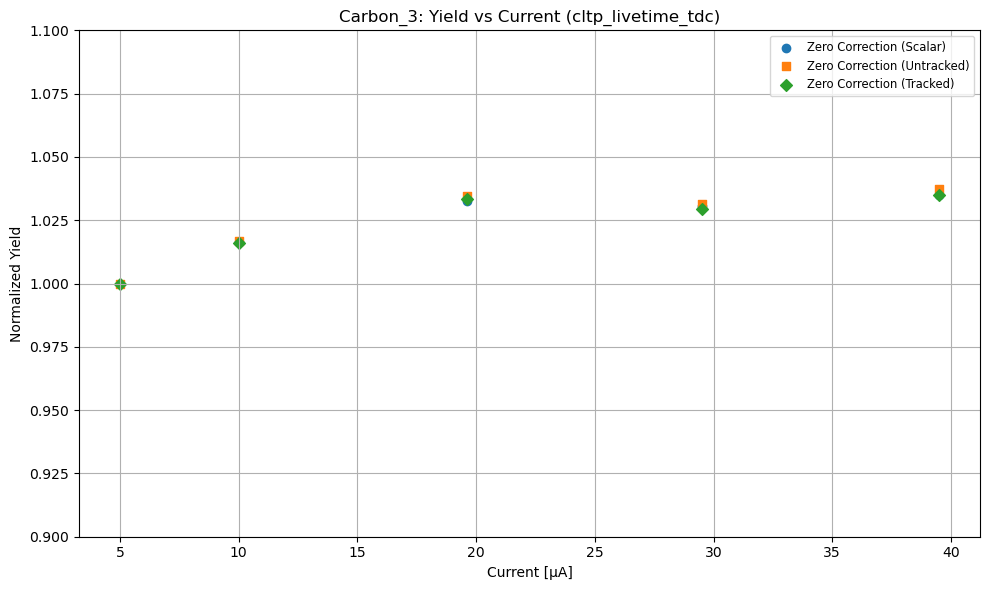

In [15]:
import matplotlib.pyplot as plt

# runs = [1523, 1524, 1525, 1526, 1528, 1530] #carbon 1
# currents = [33.5, 33.5, 38.5, 24, 14, 4.8] # carbon 1
# ps_factors = [9, 5, 5, 5, 3, 1] #carbon 1

# runs = [6845, 6846, 6847, 6848, 6849] # carbon 2
# currents = [5.1, 20.5, 15.3, 10.5, 3] # carbon 2
# ps_factors = [1, 1, 1, 1, 1] # carbon2

runs = [7003, 7004, 7005, 7006, 7007]  # carbon 3
currents = [39.5, 29.5, 19.6, 10, 5]         # carbon 3
ps_factors = [1, 1, 1, 1, 1] #carbon 3

corrections = {
    f"Zero Correction": 0.0,
    # f"Optimal Correction = {optimal_correction*1000:.0f} nA": optimal_correction
}

# Marker styles for each yield type
yield_styles = {
    "Scalar": {"marker": "o", "linestyle": "None"},
    "Untracked": {"marker": "s", "linestyle": "None"},
    "Tracked": {"marker": "D", "linestyle": "None"},
}

plt.figure(figsize=(10, 6))

for label, correction in corrections.items():
    scalar_yields = []
    untracked_yields = []
    tracked_yields = []
    valid_currents = []

    for run, current, ps_factor in zip(runs, currents, ps_factors):
        print(f'{label} | Processing run {run} at {current} μA and ps_factor {ps_factor}')
        scalar_yield, untracked_yield, tracked_yield = plot_yield_scaler(run, current, ps_factor, correction)


    ############################### Debug #######################
    #     scalar_yield = plot_yield_scaler(run, current, correction)
    #     if scalar_yield > 0:
    #         scalar_yields.append(scalar_yield)
    #         untracked_yields.append(untracked_yield)
    #         tracked_yields.append(tracked_yield)
    #         valid_currents.append(current)
    #     else:
    #         print("  Invalid or zero yield")

    # if scalar_yields:
    #     min_current_idx = valid_currents.index(min(valid_currents))
    #     norm_scalar = [y / scalar_yields[min_current_idx] for y in scalar_yields]
    #     plt.scatter(valid_currents, norm_scalar,
    #             label=f"{label} (Scalar)", **yield_styles["Scalar"])
        
    #######################################################################
        

        if scalar_yield > 0:
            scalar_yields.append(scalar_yield)
            untracked_yields.append(untracked_yield)
            tracked_yields.append(tracked_yield)
            valid_currents.append(current)
            print(f'    Scalar = {scalar_yield}, Untracked = {untracked_yield}, Tracked = {tracked_yield}')
        else:
            print("  Invalid or zero yield")

    # # Normalize each yield type separately
    # if scalar_yields:
    #     norm_scalar = [y / min(scalar_yields) for y in scalar_yields]
    #     plt.scatter(valid_currents, norm_scalar,
    #                 label=f"{label} (Scalar)", **yield_styles["Scalar"])

    # if untracked_yields:
    #     norm_untracked = [y / min(untracked_yields) for y in untracked_yields]
    #     plt.scatter(valid_currents, norm_untracked,
    #                 label=f"{label} (Untracked)", **yield_styles["Untracked"])

    # if tracked_yields:
    #     norm_tracked = [y / min(tracked_yields) for y in tracked_yields]
    #     plt.scatter(valid_currents, norm_tracked,
    #                 label=f"{label} (Tracked)", **yield_styles["Tracked"])

    if scalar_yields:
        min_current_idx = valid_currents.index(min(valid_currents))
        norm_scalar = [y / scalar_yields[min_current_idx] for y in scalar_yields]
        plt.scatter(valid_currents, norm_scalar,
                label=f"{label} (Scalar)", **yield_styles["Scalar"])

    if untracked_yields:
        min_current_idx = valid_currents.index(min(valid_currents))
        norm_untracked = [y / untracked_yields[min_current_idx] for y in untracked_yields]
        plt.scatter(valid_currents, norm_untracked,
                label=f"{label} (Untracked)", **yield_styles["Untracked"])

    if tracked_yields:
        min_current_idx = valid_currents.index(min(valid_currents))
        norm_tracked = [y / tracked_yields[min_current_idx] for y in tracked_yields]
        plt.scatter(valid_currents, norm_tracked,
                label=f"{label} (Tracked)", **yield_styles["Tracked"])


plt.xlabel('Current [μA]')
plt.ylabel('Normalized Yield')
plt.title('Carbon_3: Yield vs Current (cltp_livetime_tdc)')
plt.grid(True)
plt.ylim(0.9, 1.1)
plt.legend(fontsize='small', loc='best')
plt.tight_layout()
# plt.savefig("carbon_yield_all_types.png")
plt.show()



Processing dataset: Carbon_2
  Zero Correction | Run 6845 at 5.1 μA
/lustre24/expphy/volatile/hallc/nps/singhav/ROOTfiles/luminosity_all/nps_hms_coin_6845_0_1_-1.root
    Scalar = 37.204724798077756, Untracked = 26.51105377816203, Tracked = 22.331383137460808
  Zero Correction | Run 6846 at 20.5 μA
/lustre24/expphy/volatile/hallc/nps/singhav/ROOTfiles/luminosity_all/nps_hms_coin_6846_0_1_-1.root
    Scalar = 38.588556299434394, Untracked = 27.915177645934918, Tracked = 23.489292423836876
  Zero Correction | Run 6847 at 15.3 μA
/lustre24/expphy/volatile/hallc/nps/singhav/ROOTfiles/luminosity_all/nps_hms_coin_6847_0_1_-1.root
    Scalar = 38.50424299128632, Untracked = 27.564447139506676, Tracked = 23.18975505289613
  Zero Correction | Run 6848 at 10.5 μA
/lustre24/expphy/volatile/hallc/nps/singhav/ROOTfiles/luminosity_all/nps_hms_coin_6848_0_1_-1.root
    Scalar = 38.10158818657686, Untracked = 26.89907887857703, Tracked = 22.633109770844992
  Zero Correction | Run 6849 at 3 μA
/lustre

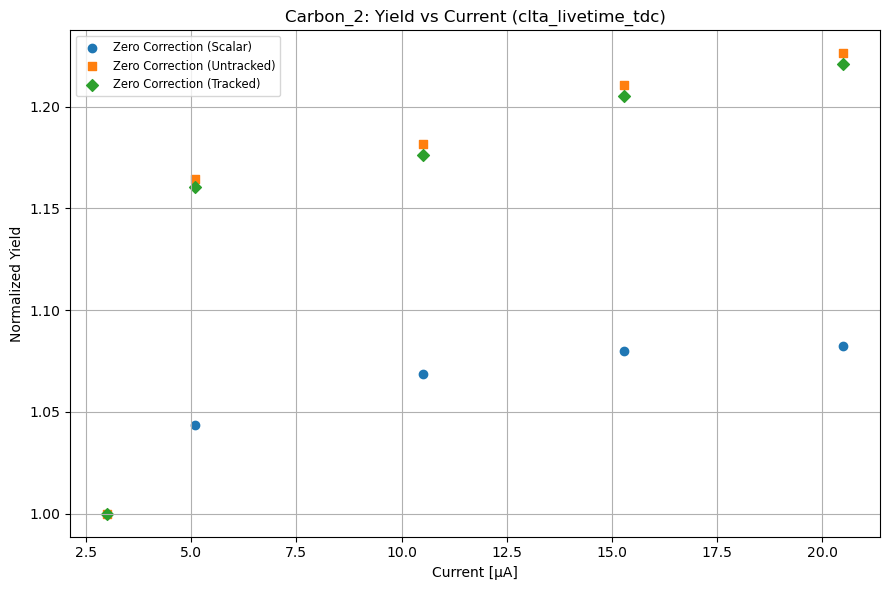

In [3]:
# datasets = {
#     "LH2_1": {
#         "runs": [1514, 1515, 1516, 1517],
#         "currents": [5, 10, 15, 25]
#     },
#     "LH2_2": {
#         "runs": [6850, 6851, 6852, 6853, 6854],
#         "currents": [5, 20, 15, 10, 3]
#     },
#     "LD2": {
#         "runs": [1518, 1519, 1520, 1521, 1522],
#         "currents": [40, 25, 18, 10, 5]
#     }
# }

# corrections = {
#     f"Zero Correction": 0.0,
#     # f"Optimal Correction = {optimal_correction*1000:.2f} nA/sqrt(Hz)": optimal_correction  # Display value in legend
# }

# for label, data in datasets.items():
#     print(f"\nProcessing dataset: {label}")
    
#     plt.figure(figsize=(8, 5))

#     for corr_label, correction in corrections.items():
#         yields = []
#         valid_currents = []

#         for run, current in zip(data["runs"], data["currents"]):
#             print(f'  {corr_label} | Run {run} at {current} uA')
#             y = plot_yield_scaler(run, current, correction)
#             if y > 0:
#                 yields.append(y)
#                 valid_currents.append(current)
#                 print(f'    Yield/Charge = {y}')
#             else:
#                 print(f'    Invalid or zero yield')

#         if yields:
#             min_yield = min(yields)
#             normalized_yields = [y / min_yield for y in yields]

#             plt.scatter(valid_currents, normalized_yields, label=corr_label)

#     plt.xlabel('Current [μA]')
#     plt.ylabel('Normalized Yield')
#     plt.title(f'{label}: Yield vs Current')
#     plt.grid(True)
#     plt.ylim(0.99, 1.06)
#     plt.legend()
#     plt.tight_layout()
#     # plt.savefig(f"/w/hallc-scshelf2102/nps/singhav/nps_analysis/luminosity_analysis/luminosity_plots/{label}_rate_3.png")
#     plt.show()

import matplotlib.pyplot as plt

datasets = {
    # "Carbon_1": {
    #     "runs": [1523, 1524, 1525, 1526, 1528, 1530],
    #     "currents": [33.5, 33.5, 38.5, 24, 14, 4.8],
    #     "ps_factors": [9, 5, 5, 5, 3, 1]
    # },
    "Carbon_2": {
        "runs": [6845, 6846, 6847, 6848, 6849],
        "currents": [5.1, 20.5, 15.3, 10.5, 3],
        "ps_factors": [1, 1, 1, 1, 1]
    }
    # ,
    # "Carbon_3": {
    #     "runs": [7003, 7004, 7005, 7006, 7007],
    #     "currents": [39.5, 29.5, 19.6, 10, 5],
    #     "ps_factors": [1, 1, 1, 1, 1]
    # },
    # "LH2_1": {
    #     "runs": [1514, 1515, 1516, 1517],
    #     "currents": [5, 10, 15, 25],
    #     "ps_factors": [1, 3, 5, 9]
    # },
    # "LH2_2": {
    #     "runs": [6850, 6851, 6852, 6853, 6854],
    #     "currents": [5, 20, 15, 10, 3],
    #     "ps_factors": [1, 1, 1, 1, 1]
    # },
    # "LD2": {
    #     "runs": [1518, 1519, 1520, 1521, 1522],
    #     "currents": [40, 25, 18, 10, 5],
    #     "ps_factors": [65, 33, 33, 17, 9]
    # }
}

corrections = {
    f"Zero Correction": 0.0,
    # f"Optimal Correction = {optimal_correction*1000:.2f} nA/sqrt(Hz)": optimal_correction
}

# Marker styles per yield type
yield_styles = {
    "Scalar": {"marker": "o"},
    "Untracked": {"marker": "s"},
    "Tracked": {"marker": "D"},
}

for dataset_label, data in datasets.items():
    print(f"\nProcessing dataset: {dataset_label}")
    plt.figure(figsize=(9, 6))

    for corr_label, correction in corrections.items():
        scalar_yields = []
        untracked_yields = []
        tracked_yields = []
        valid_currents = []

        for run, current, ps_factor in zip(data["runs"], data["currents"], data["ps_factors"]):
            print(f'  {corr_label} | Run {run} at {current} μA')
            scalar_yield, untracked_yield, tracked_yield = plot_yield_scaler(run, current, ps_factor, correction)

            if scalar_yield > 0:
                scalar_yields.append(scalar_yield)
                untracked_yields.append(untracked_yield)
                tracked_yields.append(tracked_yield)
                valid_currents.append(current)
                print(f'    Scalar = {scalar_yield}, Untracked = {untracked_yield}, Tracked = {tracked_yield}')
            else:
                print(f'    Invalid or zero yield')


        if valid_currents:
            # Normalize separately for each yield type
            if scalar_yields:
                min_current_idx = valid_currents.index(min(valid_currents))
                norm_scalar = [y / scalar_yields[min_current_idx] for y in scalar_yields]
                plt.scatter(valid_currents, norm_scalar,
                            label=f"{corr_label} (Scalar)", **yield_styles["Scalar"])
            if untracked_yields:
                min_current_idx = valid_currents.index(min(valid_currents))
                norm_untracked = [y / untracked_yields[min_current_idx] for y in untracked_yields]
                plt.scatter(valid_currents, norm_untracked,
                            label=f"{corr_label} (Untracked)", **yield_styles["Untracked"])
            if tracked_yields:
                min_current_idx = valid_currents.index(min(valid_currents))
                norm_tracked = [y / tracked_yields[min_current_idx] for y in tracked_yields]
                plt.scatter(valid_currents, norm_tracked,
                            label=f"{corr_label} (Tracked)", **yield_styles["Tracked"])

    plt.xlabel('Current [μA]')
    plt.ylabel('Normalized Yield')
    plt.title(f'{dataset_label}: Yield vs Current (clta_livetime_tdc)')
    plt.grid(True)
    # plt.ylim(0.99, 1.09)
    plt.legend(fontsize='small', loc='best')
    plt.tight_layout()
    plt.savefig(f"/w/hallc-scshelf2102/nps/singhav/nps_analysis/luminosity_analysis/luminosity_plots/zero_correction_yields_clta_livetime_tdc//{dataset_label}_yield_zero_correction.png")
    plt.show()



Processing dataset: Carbon_1
Processing run 1523 at 33.5 μA, ps_factor 9
/lustre24/expphy/volatile/hallc/nps/singhav/ROOTfiles/luminosity/nps_hms_coin_1523_0_1_-1.root
/lustre24/expphy/volatile/hallc/nps/singhav/ROOTfiles/luminosity/nps_hms_coin_1523_1_1_-1.root
/lustre24/expphy/volatile/hallc/nps/singhav/ROOTfiles/luminosity/nps_hms_coin_1523_2_1_-1.root
t_edtm_accepted: 5447
t_hTRIG4_all_accepted: 180135
t_hTRIG4_phy_accepted: 174688
trig_accp_total: 176861.0
scaler_hTRIG4_total: 1607912.0
scaler_edtm_total: 46147.0
beam_on_percent_edtm: 0.9517
beam_on_percent_trig_accp: 0.9904
Run 1523: TLT Livetime edtm = 1.0110
Run 1523: All Livetime tsh = 0.9899
Run 1523: All Livetime tdc = 0.9986
Run 1523: Physics Livetime tdc = 0.9970
Processing run 1524 at 33.5 μA, ps_factor 5
/lustre24/expphy/volatile/hallc/nps/singhav/ROOTfiles/luminosity/nps_hms_coin_1524_0_1_-1.root
/lustre24/expphy/volatile/hallc/nps/singhav/ROOTfiles/luminosity/nps_hms_coin_1524_1_1_-1.root
t_edtm_accepted: 13359
t_hTRI

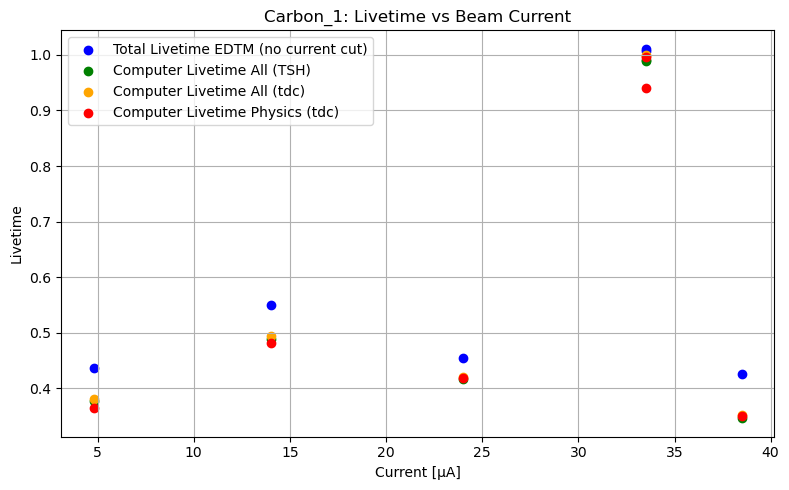


Processing dataset: Carbon_2
Processing run 6845 at 5.1 μA, ps_factor 1
/lustre24/expphy/volatile/hallc/nps/singhav/ROOTfiles/luminosity/nps_hms_coin_6845_0_1_-1.root
t_edtm_accepted: 24612
t_hTRIG4_all_accepted: 132155
t_hTRIG4_phy_accepted: 107543
trig_accp_total: 128262.0
scaler_hTRIG4_total: 128276.0
scaler_edtm_total: 22435.0
beam_on_percent_edtm: 0.9121
beam_on_percent_trig_accp: 0.9705
Run 6845: TLT Livetime edtm = 1.0007
Run 6845: All Livetime tsh = 0.9999
Run 6845: All Livetime tdc = 0.9999
Run 6845: Physics Livetime tdc = 0.9862
Processing run 6846 at 20.5 μA, ps_factor 1
/lustre24/expphy/volatile/hallc/nps/singhav/ROOTfiles/luminosity/nps_hms_coin_6846_0_1_-1.root
t_edtm_accepted: 23349
t_hTRIG4_all_accepted: 484298
t_hTRIG4_phy_accepted: 460949
trig_accp_total: 484297.0
scaler_hTRIG4_total: 484575.0
scaler_edtm_total: 23303.0
beam_on_percent_edtm: 1.0000
beam_on_percent_trig_accp: 1.0000
Run 6846: TLT Livetime edtm = 1.0020
Run 6846: All Livetime tsh = 0.9994
Run 6846: All

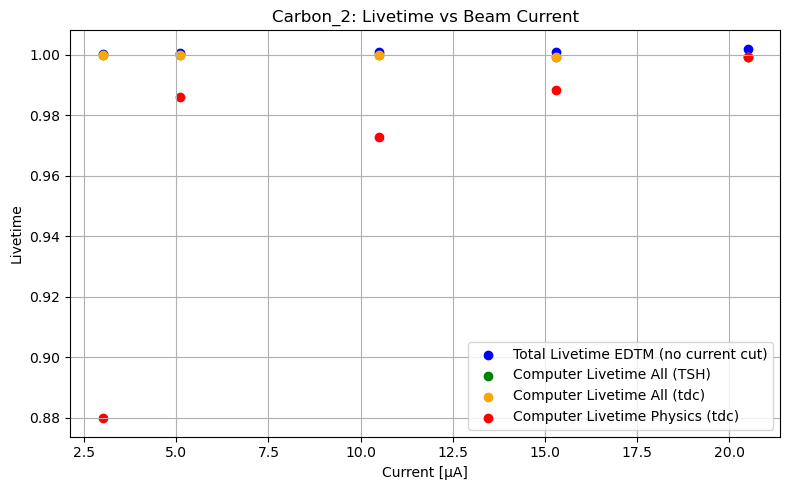


Processing dataset: Carbon_3
Processing run 7003 at 39.5 μA, ps_factor 1
/lustre24/expphy/volatile/hallc/nps/singhav/ROOTfiles/luminosity/nps_hms_coin_7003_0_1_-1.root
t_edtm_accepted: 13827
t_hTRIG4_all_accepted: 211969
t_hTRIG4_phy_accepted: 198142
trig_accp_total: 211968.0
scaler_hTRIG4_total: 212048.0
scaler_edtm_total: 13795.0
beam_on_percent_edtm: 1.0000
beam_on_percent_trig_accp: 1.0000
Run 7003: TLT Livetime edtm = 1.0023
Run 7003: All Livetime tsh = 0.9996
Run 7003: All Livetime tdc = 0.9996
Run 7003: Physics Livetime tdc = 0.9994
Processing run 7004 at 29.5 μA, ps_factor 1
/lustre24/expphy/volatile/hallc/nps/singhav/ROOTfiles/luminosity/nps_hms_coin_7004_0_1_-1.root
t_edtm_accepted: 19205
t_hTRIG4_all_accepted: 207861
t_hTRIG4_phy_accepted: 188656
trig_accp_total: 196826.0
scaler_hTRIG4_total: 196882.0
scaler_edtm_total: 16762.0
beam_on_percent_edtm: 0.8739
beam_on_percent_trig_accp: 0.9469
Run 7004: TLT Livetime edtm = 1.0013
Run 7004: All Livetime tsh = 0.9997
Run 7004: Al

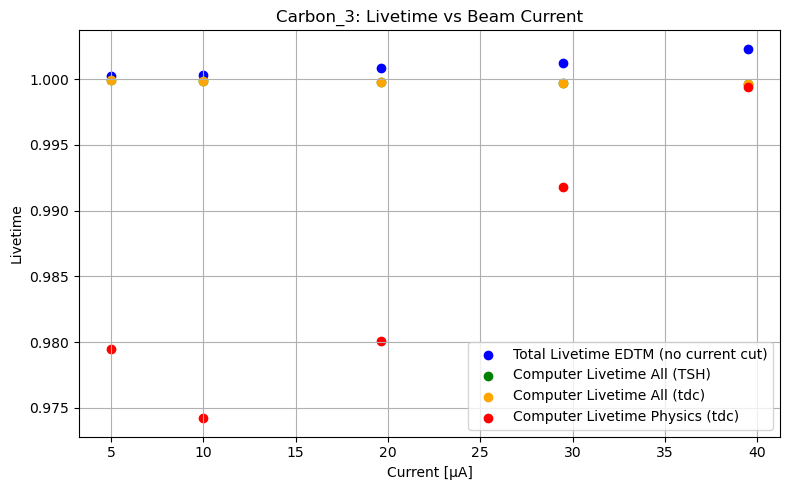


Processing dataset: LH2_1
Processing run 1514 at 5 μA, ps_factor 1
/lustre24/expphy/volatile/hallc/nps/singhav/ROOTfiles/luminosity/nps_hms_coin_1514_0_1_-1.root
/lustre24/expphy/volatile/hallc/nps/singhav/ROOTfiles/luminosity/nps_hms_coin_1514_10_1_-1.root
/lustre24/expphy/volatile/hallc/nps/singhav/ROOTfiles/luminosity/nps_hms_coin_1514_11_1_-1.root
/lustre24/expphy/volatile/hallc/nps/singhav/ROOTfiles/luminosity/nps_hms_coin_1514_12_1_-1.root
/lustre24/expphy/volatile/hallc/nps/singhav/ROOTfiles/luminosity/nps_hms_coin_1514_1_1_-1.root
/lustre24/expphy/volatile/hallc/nps/singhav/ROOTfiles/luminosity/nps_hms_coin_1514_2_1_-1.root
/lustre24/expphy/volatile/hallc/nps/singhav/ROOTfiles/luminosity/nps_hms_coin_1514_3_1_-1.root
/lustre24/expphy/volatile/hallc/nps/singhav/ROOTfiles/luminosity/nps_hms_coin_1514_4_1_-1.root
/lustre24/expphy/volatile/hallc/nps/singhav/ROOTfiles/luminosity/nps_hms_coin_1514_5_1_-1.root
/lustre24/expphy/volatile/hallc/nps/singhav/ROOTfiles/luminosity/nps_hms_c

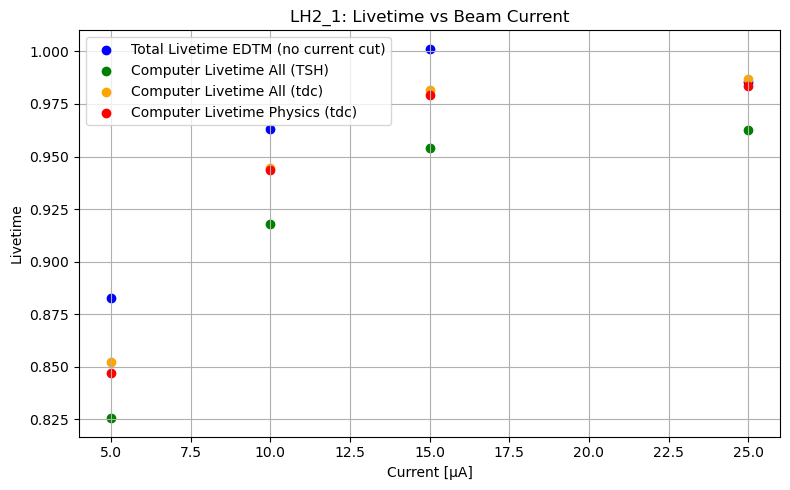


Processing dataset: LH2_2
Processing run 6850 at 5 μA, ps_factor 1
/lustre24/expphy/volatile/hallc/nps/singhav/ROOTfiles/luminosity/nps_hms_coin_6850_0_1_-1.root
t_edtm_accepted: 24326
t_hTRIG4_all_accepted: 170850
t_hTRIG4_phy_accepted: 146524
trig_accp_total: 170849.0
scaler_hTRIG4_total: 170875.0
scaler_edtm_total: 24308.0
beam_on_percent_edtm: 1.0000
beam_on_percent_trig_accp: 1.0000
Run 6850: TLT Livetime edtm = 1.0007
Run 6850: All Livetime tsh = 0.9998
Run 6850: All Livetime tdc = 0.9999
Run 6850: Physics Livetime tdc = 0.9997
Processing run 6851 at 20 μA, ps_factor 1
/lustre24/expphy/volatile/hallc/nps/singhav/ROOTfiles/luminosity/nps_hms_coin_6851_0_1_-1.root
/lustre24/expphy/volatile/hallc/nps/singhav/ROOTfiles/luminosity/nps_hms_coin_6851_1_1_-1.root
t_edtm_accepted: 26758
t_hTRIG4_all_accepted: 558427
t_hTRIG4_phy_accepted: 531669
trig_accp_total: 517422.0
scaler_hTRIG4_total: 518964.0
scaler_edtm_total: 21687.0
beam_on_percent_edtm: 0.8131
beam_on_percent_trig_accp: 0.929

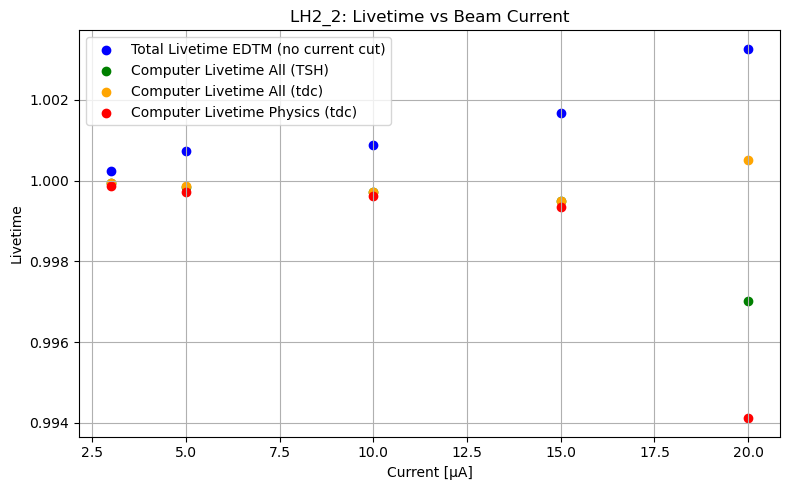


Processing dataset: LD2
Processing run 1518 at 40 μA, ps_factor 65
/lustre24/expphy/volatile/hallc/nps/singhav/ROOTfiles/luminosity/nps_hms_coin_1518_0_1_-1.root
/lustre24/expphy/volatile/hallc/nps/singhav/ROOTfiles/luminosity/nps_hms_coin_1518_1_1_-1.root
/lustre24/expphy/volatile/hallc/nps/singhav/ROOTfiles/luminosity/nps_hms_coin_1518_2_1_-1.root
/lustre24/expphy/volatile/hallc/nps/singhav/ROOTfiles/luminosity/nps_hms_coin_1518_3_1_-1.root
/lustre24/expphy/volatile/hallc/nps/singhav/ROOTfiles/luminosity/nps_hms_coin_1518_4_1_-1.root
/lustre24/expphy/volatile/hallc/nps/singhav/ROOTfiles/luminosity/nps_hms_coin_1518_5_1_-1.root
/lustre24/expphy/volatile/hallc/nps/singhav/ROOTfiles/luminosity/nps_hms_coin_1518_6_1_-1.root
t_edtm_accepted: 1549
t_hTRIG4_all_accepted: 521346
t_hTRIG4_phy_accepted: 519797
trig_accp_total: 37414.0
scaler_hTRIG4_total: 2455764.0
scaler_edtm_total: 6070.0
beam_on_percent_edtm: 0.0706
beam_on_percent_trig_accp: 0.0728
Run 1518: TLT Livetime edtm = 1.1713
Run

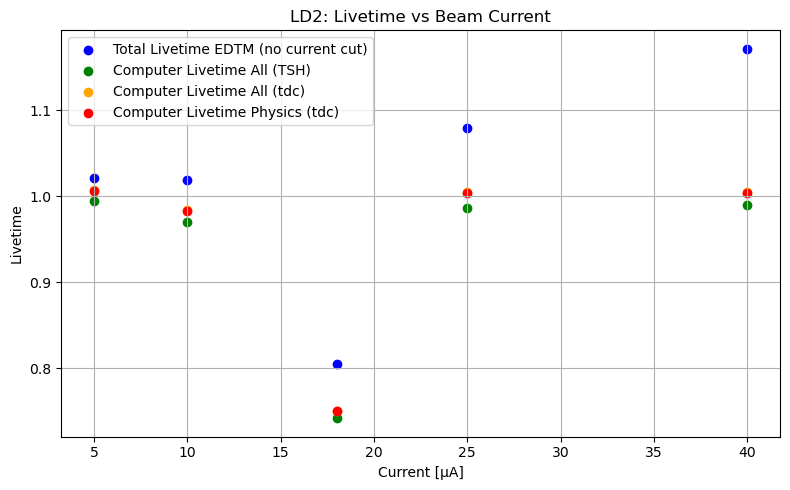

In [10]:
import ROOT
import numpy as np
import os
import matplotlib.pyplot as plt
from array import array
from scipy.optimize import minimize_scalar
import math
from pathlib import Path
import csv

# Configuration
directory = Path("/lustre24/expphy/volatile/hallc/nps/singhav/ROOTfiles/luminosity")

datasets = {
    "Carbon_1": {
        "runs": [1523, 1524, 1525, 1526, 1528, 1530],
        "currents": [33.5, 33.5, 38.5, 24, 14, 4.8],
        "ps_factors": [9, 5, 5, 5, 3, 1]
    },
    "Carbon_2": {
        "runs": [6845, 6846, 6847, 6848, 6849],
        "currents": [5.1, 20.5, 15.3, 10.5, 3],
        "ps_factors": [1, 1, 1, 1, 1]
    },
    "Carbon_3": {
        "runs": [7003, 7004, 7005, 7006, 7007],
        "currents": [39.5, 29.5, 19.6, 10, 5],
        "ps_factors": [1, 1, 1, 1, 1]
    },
    "LH2_1": {
        "runs": [1514, 1515, 1516, 1517],
        "currents": [5, 10, 15, 25],
        "ps_factors": [1, 3, 5, 9]
    },
    "LH2_2": {
        "runs": [6850, 6851, 6852, 6853, 6854],
        "currents": [5, 20, 15, 10, 3],
        "ps_factors": [1, 1, 1, 1, 1]
    },
    "LD2": {
        "runs": [1518, 1519, 1520, 1521, 1522],
        "currents": [40, 25, 18, 10, 5],
        "ps_factors": [65, 33, 33, 17, 9]
    }
}

# run_numbers = [1523, 1524, 1525, 1526, 1528, 1530]  # Replace with actual runs
# currents = [33.5, 33.5, 38.5, 24, 14, 4.8]               # Corresponding expected beam currents
# ps_factors = [9, 5, 5, 5, 3, 1]
current_threshold = 1.0

def get_segment_files(run):
    """Returns all segment files for a given run."""
    return sorted(directory.glob(f"nps_hms_coin_{run}_*_1_-1.root"))

def analyze_run(run, expected_current):
    """Analyzes all segments for a run and returns scaler EDTM and triggered EDTM counts."""
    scaler_edtm_total = 0
    scaler_hTRIG4_total = 0
    scaler_hEL_REAL_total = 0
    trig_accp_total = 0
    trig_accp_no_cut = 0
    t_edtm_accepted = 0
    scaler_edtm_no_cut = 0
    t_hTRIG4_all_accepted = 0
    t_hTRIG4_phy_accepted = 0

    prev_EDTM = 0
    prev_accp = 0
    prev_hTRIG4 = 0
    prev_hEL_REAL = 0
    
    segment_files = get_segment_files(run)

    for fpath in segment_files:
        print(fpath)
        root_file = ROOT.TFile(str(fpath))
        tsh_tree = root_file.Get("TSH")
        t_tree = root_file.Get("T")

        if not tsh_tree or not t_tree:
            print(f"Skipping: Couldn't load TSH or T from {fpath.name}")
            continue

        # Define ROOT-compatible arrays
        H_BCM4A_scalerCurrent = array('d', [0.])
        
        H_EDTM_scaler = array('d', [0.])
        H_hTRIG4_scaler = array('d', [0.])
        H_hL1ACCP_scaler = array('d', [0.])
        H_hEL_REAL_scaler = array('d', [0.])

        T_hms_hEDTM_tdcTimeRaw = array('d', [0.])
        T_hms_hTRIG4_tdcTimeRaw = array('d', [0.])

        # Disable all branches
        # tsh_tree.SetBranchStatus("*", 0)
        # t_tree.SetBranchStatus("*", 0)

        # # # Enable only the branches you use from TSH
        # tsh_tree.SetBranchStatus("H.BCM4A.scalerCharge", 1)
        # tsh_tree.SetBranchStatus("H.EDTM.scaler", 1)
        # tsh_tree.SetBranchStatus("H.hTRIG4.scaler", 1)
        # tsh_tree.SetBranchStatus("H.hL1ACCP.scaler", 1)
        # tsh_tree.SetBranchStatus("H.hEL_REAL.scaler", 1)
        
        # t_tree.SetBranchStatus("T.hms.hEDTM_tdcTimeRaw", 1)
        # t_tree.SetBranchStatus("T.hms.hTRIG4_tdcTimeRaw", 1)

        tsh_tree.SetBranchAddress("H.BCM4A.scalerCurrent", H_BCM4A_scalerCurrent)
        tsh_tree.SetBranchAddress("H.EDTM.scaler", H_EDTM_scaler)
        tsh_tree.SetBranchAddress("H.hTRIG4.scaler", H_hTRIG4_scaler)
        tsh_tree.SetBranchAddress("H.hL1ACCP.scaler", H_hL1ACCP_scaler)
        tsh_tree.SetBranchAddress("H.hEL_REAL.scaler", H_hEL_REAL_scaler)

        t_tree.SetBranchAddress("T.hms.hEDTM_tdcTimeRaw", T_hms_hEDTM_tdcTimeRaw)
        t_tree.SetBranchAddress("T.hms.hTRIG4_tdcTimeRaw", T_hms_hTRIG4_tdcTimeRaw)

        nentries = tsh_tree.GetEntries()
        # if nentries < 2:
        #     print(f"Error: Not enough scaler entries in run {run}")
        # return -1

        # accumulated_edtm = 0
        # prev_EDTM = 0
        # prev_accp = 0
        # prev_hTRIG4 = 0
        # prev_hEL_REAL = 0


        for i in range(nentries):
            tsh_tree.GetEntry(i)

            if i == 0:
                prev_EDTM = H_EDTM_scaler[0]
                prev_hTRIG4 = H_hTRIG4_scaler[0]
                prev_accp = H_hL1ACCP_scaler[0]
                prev_hEL_REAL = H_hEL_REAL_scaler[0]
                continue
            
            scaler_edtm_no_cut += (H_EDTM_scaler[0] - prev_EDTM)
            trig_accp_no_cut += (H_hL1ACCP_scaler[0] - prev_accp)
            
            if abs(H_BCM4A_scalerCurrent[0] - expected_current) < 1.0 :
                scaler_edtm_total += (H_EDTM_scaler[0] - prev_EDTM)
                scaler_hTRIG4_total += (H_hTRIG4_scaler[0] - prev_hTRIG4)
                trig_accp_total += (H_hL1ACCP_scaler[0] - prev_accp)
                scaler_hEL_REAL_total += (H_hEL_REAL_scaler[0] - prev_hEL_REAL)
                # print('scaler edtm total: ',scaler_edtm_total)

            prev_EDTM = H_EDTM_scaler[0]
            prev_hTRIG4 = H_hTRIG4_scaler[0]
            prev_accp = H_hL1ACCP_scaler[0]
            prev_hEL_REAL = H_hEL_REAL_scaler[0]

        beam_on_percent_edtm = (scaler_edtm_total/scaler_edtm_no_cut)
        beam_on_percent_trig_accp = (trig_accp_total/trig_accp_no_cut)
        nentries_t = t_tree.GetEntries()

        for i in range(nentries_t):
            t_tree.GetEntry(i)

            if T_hms_hEDTM_tdcTimeRaw[0] != 0:
                t_edtm_accepted += 1

            if T_hms_hTRIG4_tdcTimeRaw[0] != 0:
                t_hTRIG4_all_accepted += 1

            if T_hms_hTRIG4_tdcTimeRaw[0] !=0 and T_hms_hEDTM_tdcTimeRaw[0] == 0:
                t_hTRIG4_phy_accepted += 1

        # # Scale counts by beam-on percentage
        # t_edtm_accepted *= beam_on_percent
        # t_hTRIG4_phy_accepted *= beam_on_percent
        # t_hTRIG4_all_accepted *= beam_on_percent

        root_file.Close()
        
    # return scaler_edtm_total, scaler_hTRIG4_total, trig_accp_total, scaler_hEL_REAL_total, scaler_edtm_no_cut, t_edtm_accepted
    return t_edtm_accepted, t_hTRIG4_all_accepted, t_hTRIG4_phy_accepted, trig_accp_total, scaler_hTRIG4_total, scaler_edtm_total, beam_on_percent_edtm, beam_on_percent_trig_accp

edtm_ratio_tdc = []   #stores the accepted_edtm/scaler_edtm
runs = [] #stores the run numbers
ps_fac = [] #stores the ps_factors
livetimes_clta_tsh = []
livetimes_clta_tdc = [] #stores the livetime (clta)
livetimes_cltp_tdc = [] #stores the livetime (cltp)
livetimes_tlt_edtm = [] #stores the total livetime calculated by edtm

output_filename = "/w/hallc-scshelf2102/nps/singhav/nps_analysis/luminosity_analysis/livetime_results_maybe_corrected.csv"

# Write header only once
with open(output_filename, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow([
        "run", "current", 
        "t_edtm_accepted", "t_hTRIG4_all_accepted", "t_hTRIG4_phy_accepted", 
        "trig_accp_total", "scaler_hTRIG4_total", "scaler_edtm_total", 
        "beam_on_percent_edtm", "beam_on_percent_trig_accp", 
        "TLT_livetime_edtm", "CLTA_livetime_tsh", "CLTA_livetime_tdc", "CLTP_livetime_tdc"
    ])


for label, data in datasets.items():
    print(f"\nProcessing dataset: {label}")
    
    plt.figure(figsize=(8, 5))

    clta_livetimes_tsh = []
    clta_livetimes_tdc = []
    cltp_livetimes_tdc = []
    tlt_livetimes_edtm = []
    valid_currents = []


    for run, current, ps_factor in zip(data["runs"], data["currents"], data["ps_factors"]):
        print(f"Processing run {run} at {current} μA, ps_factor {ps_factor}")
        # scaler_edtm, scaler_hTRIG4, trig_accp, scaler_hEL_REAL, scaler_edtm_no_cut, t_edtm_accepted = analyze_run(run, current)
        t_edtm_accepted, t_hTRIG4_all_accepted, t_hTRIG4_phy_accepted, trig_accp_total, scaler_hTRIG4_total, scaler_edtm_total, beam_on_percent_edtm, beam_on_percent_trig_accp = analyze_run(run, current)
        # beam_on_percent_edtm=beam_on_percent_edtm/(2/ps_factor)
        # edtm_ratio_tdc.append((t_edtm_accepted/(scaler_edtm_total/beam_on_percent_edtm))*ps_factor)
        runs.append(run)
        ps_fac.append(ps_factor)

        if scaler_edtm_total > 0 and scaler_hTRIG4_total> 0:
            # print('edtm:hTRIG4:accp:EL_REAL:scaler_edtm_no_cut:t_edtm_accepted ',scaler_edtm, scaler_hTRIG4, trig_accp, scaler_hEL_REAL, scaler_edtm_no_cut, t_edtm_accepted)
            # print('t_edtm_accepted, t_hTRIG4_all_accepted, t_hTRIG4_phy_accepted, trig_accp_total, scaler_hTRIG4_total, scaler_edtm_total, beam_on_percent_edtm, beam_on_percent_trig_accp: ', t_edtm_accepted, t_hTRIG4_all_accepted, t_hTRIG4_phy_accepted, trig_accp_total, scaler_hTRIG4_total, scaler_edtm_total, beam_on_percent_edtm, beam_on_percent_trig_accp)
            print(
                f"t_edtm_accepted: {t_edtm_accepted}\n"
                f"t_hTRIG4_all_accepted: {t_hTRIG4_all_accepted}\n"
                f"t_hTRIG4_phy_accepted: {t_hTRIG4_phy_accepted}\n"
                f"trig_accp_total: {trig_accp_total}\n"
                f"scaler_hTRIG4_total: {scaler_hTRIG4_total}\n"
                f"scaler_edtm_total: {scaler_edtm_total}\n"
                f"beam_on_percent_edtm: {beam_on_percent_edtm:.4f}\n"
                f"beam_on_percent_trig_accp: {beam_on_percent_trig_accp:.4f}"
            )

            
            clta_livetime_tsh = ((trig_accp_total)/(scaler_hTRIG4_total))*ps_factor #already accounts for the current cut while looping over the scalers
            clta_livetime_tdc = ( (t_hTRIG4_all_accepted)/(scaler_hTRIG4_total) )*ps_factor*beam_on_percent_trig_accp #accounting for the triggers accepted only in the current cut
            cltp_livetime_tdc = ( (t_hTRIG4_phy_accepted) / (scaler_hTRIG4_total - scaler_edtm_total))*ps_factor*beam_on_percent_trig_accp #accounting for the triggers accepted only in the current cut
            tlt_livetime_edtm = (t_edtm_accepted/(scaler_edtm_total/beam_on_percent_edtm))*ps_factor #edtm_accepted/edtm_given for no cut on current

            clta_livetimes_tsh.append(clta_livetime_tsh)
            clta_livetimes_tdc.append(clta_livetime_tdc)
            cltp_livetimes_tdc.append(cltp_livetime_tdc)
            tlt_livetimes_edtm.append(tlt_livetime_edtm)
            
            livetimes_clta_tsh.append(clta_livetime_tsh)
            livetimes_clta_tdc.append(clta_livetime_tdc)
            livetimes_cltp_tdc.append(cltp_livetime_tdc)
            livetimes_tlt_edtm.append(tlt_livetime_edtm)
            # cltp_livetimes.append(cltp_livetime)
            # valid_currents.append(current)
            valid_currents.append(current)
            print(f"Run {run}: TLT Livetime edtm = {tlt_livetime_edtm:.4f}")
            print(f"Run {run}: All Livetime tsh = {clta_livetime_tsh:.4f}")
            print(f"Run {run}: All Livetime tdc = {clta_livetime_tdc:.4f}")
            print(f"Run {run}: Physics Livetime tdc = {cltp_livetime_tdc:.4f}")
        else:(
            print(f"Run {run}: Skipping due to zero counts.")
        )

        with open(output_filename, mode='a', newline='') as file:
            writer = csv.writer(file)
            writer.writerow([
            run, current, t_edtm_accepted, t_hTRIG4_all_accepted, t_hTRIG4_phy_accepted, trig_accp_total, scaler_hTRIG4_total, scaler_edtm_total, 
            beam_on_percent_edtm, beam_on_percent_trig_accp, tlt_livetime_edtm, clta_livetime_tsh, clta_livetime_tdc, cltp_livetime_tdc
            ])
        
        
    plt.scatter(valid_currents, tlt_livetimes_edtm, color='blue', label='Total Livetime EDTM (no current cut)')
    plt.scatter(valid_currents, clta_livetimes_tsh, color='green', label='Computer Livetime All (TSH)')
    plt.scatter(valid_currents, clta_livetimes_tdc, color='orange', label='Computer Livetime All (tdc)')
    plt.scatter(valid_currents, cltp_livetimes_tdc, color='red', label='Computer Livetime Physics (tdc)')
    plt.xlabel('Current [μA]')
    plt.ylabel('Livetime')
    plt.title(f'{label}: Livetime vs Beam Current')
    plt.grid(True)
    # plt.ylim(0.0, 1.1)
    plt.legend()
    plt.tight_layout()
    plt.show()



In [23]:
from IPython.display import display, HTML
import pandas as pd

# Read your CSV file
# df = pd.read_csv("/w/hallc-scshelf2102/nps/singhav/nps_analysis/luminosity_analysis/livetime_results.csv")
df = pd.read_csv("/w/hallc-scshelf2102/nps/singhav/nps_analysis/luminosity_analysis/livetime_results_maybe_corrected.csv")

# Sort by run number
df = df.sort_values("run").reset_index(drop=True)

# Print a nice table in terminal or notebook
# print(df.to_string(index=False))

display(HTML(df.to_html(index=False)))


run,current,t_edtm_accepted,t_hTRIG4_all_accepted,t_hTRIG4_phy_accepted,trig_accp_total,scaler_hTRIG4_total,scaler_edtm_total,beam_on_percent_edtm,beam_on_percent_trig_accp,TLT_livetime_edtm,CLTA_livetime_tsh,CLTA_livetime_tdc,CLTP_livetime_tdc
1514,5.0,53860,1023966,970106,967135.0,1171547.0,54312.0,0.890040,0.975291,0.882632,0.825520,0.852433,0.846855
1515,10.0,22938,912408,889470,877594.0,2867701.0,68300.0,0.955913,0.989727,0.963107,0.918081,0.944696,0.943415
1516,15.0,13750,751598,737848,697770.0,3655941.0,58976.0,0.858907,0.954837,1.001252,0.954296,0.981489,0.979332
1517,25.0,10322,811950,801628,311961.0,2916892.0,28130.0,0.298430,0.393859,0.985551,0.962548,0.986717,0.983659
1518,40.0,1549,521346,519797,37414.0,2455764.0,6070.0,0.070612,0.072784,1.171260,0.990287,1.004354,1.003851
1519,25.0,2114,485796,483682,218926.0,7327714.0,29188.0,0.451379,0.459222,1.078838,0.985922,1.004668,1.004296
1520,18.0,1758,289841,288083,266261.0,11841187.0,65708.0,0.912079,0.929196,0.805280,0.742038,0.750560,0.750171
1521,10.0,3540,328346,324806,318477.0,5583817.0,55509.0,0.939716,0.984196,1.018791,0.969607,0.983855,0.983020
1522,5.0,7154,345025,337871,337320.0,3054506.0,60028.0,0.952145,0.990512,1.021271,0.993902,1.006960,1.005848
1523,33.5,5447,180135,174688,176861.0,1607912.0,46147.0,0.951700,0.990391,1.011013,0.989948,0.998585,0.997003


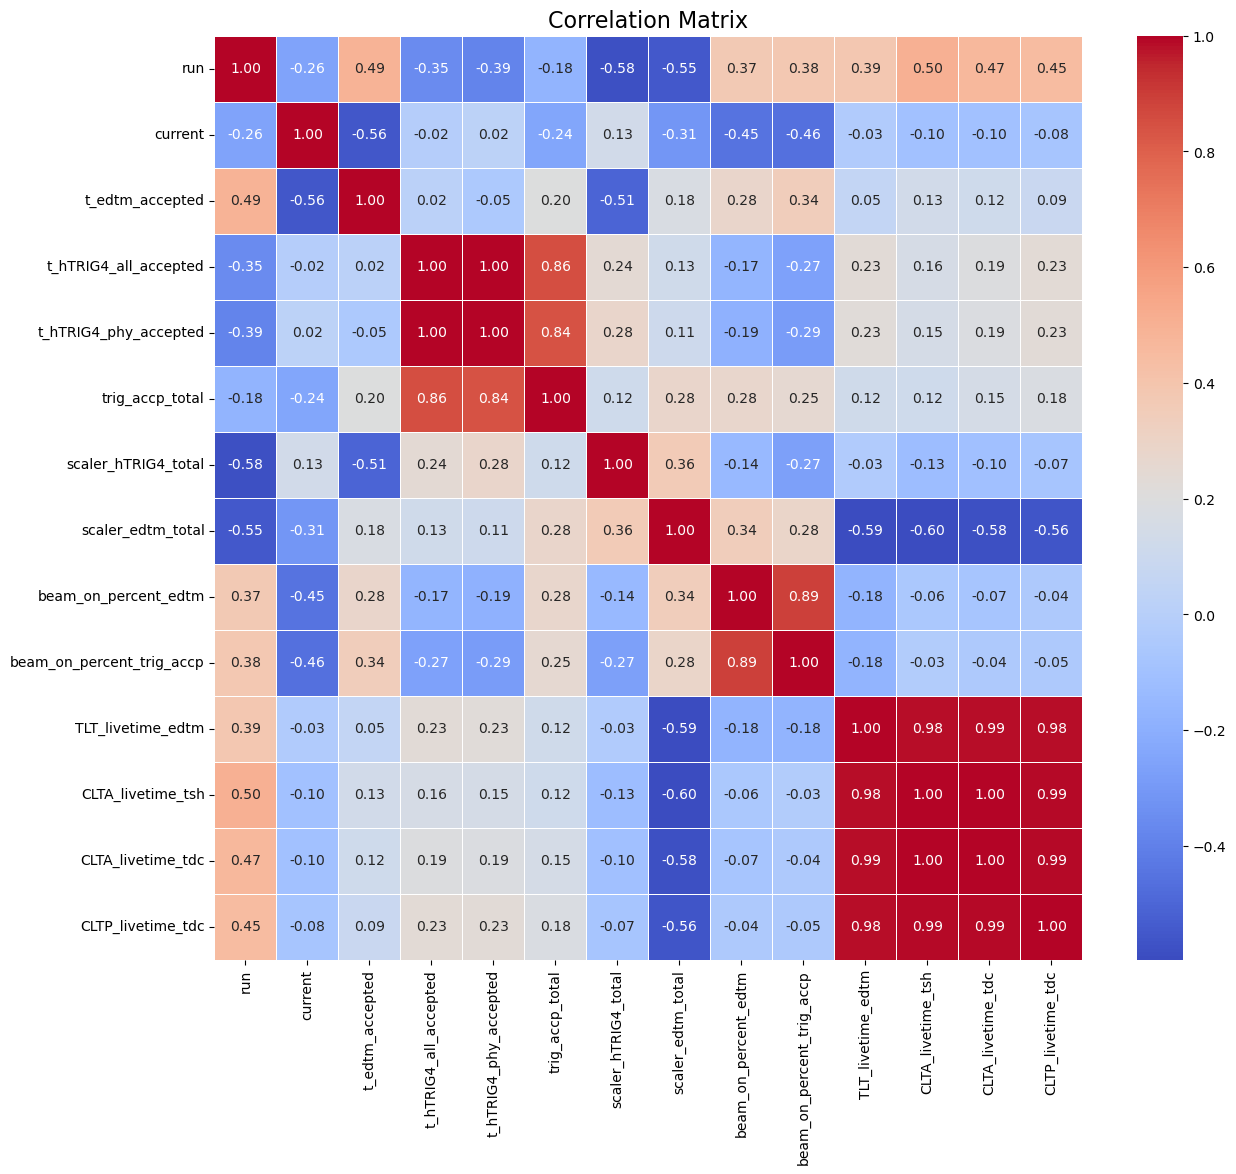

In [6]:
# Import necessary libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Define the data
# data = {
#     "run": [1514, 1515, 1516, 1517, 1518, 1519, 1520, 1521, 1522, 1523, 1524, 1525, 1526, 1528, 1530, 6845, 6846, 6847, 6848, 6849, 6850, 6851, 6852, 6853, 6854, 7003, 7004, 7005, 7006, 7007],
#     "current": [5.0, 10.0, 15.0, 25.0, 40.0, 25.0, 18.0, 10.0, 5.0, 33.5, 33.5, 38.5, 24.0, 14.0, 4.8, 5.1, 20.5, 15.3, 10.5, 3.0, 5.0, 20.0, 15.0, 10.0, 3.0, 39.5, 29.5, 19.6, 10.0, 5.0],
#     "t_edtm_accepted": [53860, 22938, 13750, 10322, 1549, 2114, 1758, 3540, 7154, 5447, 13359, 5843, 6367, 13649, 40293, 24612, 23349, 24330, 24850, 34561, 24326, 26758, 24422, 24784, 24368, 13827, 19205, 29563, 53562, 77692],
#     "t_hTRIG4_all_accepted": [1023966, 912408, 751598, 811950, 521346, 485796, 289841, 328346, 345025, 180135, 156607, 187356, 144809, 153366, 190627, 132155, 484298, 327025, 215976, 95241, 170850, 558427, 440519, 315564, 118049, 211969, 207861, 211677, 221432, 207912],
#     "t_hTRIG4_phy_accepted": [970106, 889470, 737848, 801628, 519797, 483682, 288083, 324806, 337871, 174688, 143248, 181513, 138442, 139717, 150334, 107543, 460949, 302695, 191126, 60680, 146524, 531669, 416097, 290780, 93681, 198142, 188656, 182114, 167870, 130220],
#     "trig_accp_total": [967135.0, 877594.0, 697770.0, 311961.0, 37414.0, 218926.0, 266261.0, 318477.0, 337320.0, 176861.0, 128991.0, 156769.0, 138238.0, 132149.0, 172667.0, 128262.0, 484297.0, 316269.0, 209844.0, 83322.0, 170849.0, 517422.0, 440518.0, 315563.0, 118048.0, 211968.0, 196826.0, 199029.0, 208538.0, 202692.0],
#     "scaler_hTRIG4_total": [1171547.0, 2867701.0, 3655941.0, 2916892.0, 2455764.0, 7327714.0, 11841187.0, 5583817.0, 3054506.0, 1607912.0, 651280.0, 2264860.0, 1659413.0, 810056.0, 457404.0, 128276.0, 484575.0, 316493.0, 209875.0, 83328.0, 170875.0, 518964.0, 440746.0, 315653.0, 118056.0, 212048.0, 196882.0, 199074.0, 208565.0, 202710.0],
#     "scaler_edtm_total": [54312.0, 68300.0, 58976.0, 28130.0, 6070.0, 29188.0, 65708.0, 55509.0, 60028.0, 46147.0, 18721.0, 56984.0, 65953.0, 52457.0, 79486.0, 22435.0, 23303.0, 20258.0, 19019.0, 22996.0, 24308.0, 21687.0, 24381.0, 24762.0, 24362.0, 13795.0, 16762.0, 24366.0, 46283.0, 73102.0],
#     "beam_on_percent_edtm": [0.890040, 0.955913, 0.858907, 0.298430, 0.070612, 0.451379, 0.912079, 0.939716, 0.952145, 0.951700, 0.282147, 0.831179, 0.942738, 0.704111, 0.860732, 0.912140, 1.000000, 0.833525, 0.765999, 0.665548, 1.000000, 0.813130, 1.000000, 1.000000, 1.000000, 1.000000, 0.873886, 0.824904, 0.864408, 0.941139],
#     "beam_on_percent_trig_accp": [0.975291, 0.989727, 0.954837, 0.393859, 0.072784, 0.459222, 0.929196, 0.984196, 0.990512, 0.990391, 0.830967, 0.850799, 0.964110, 0.870983, 0.915660, 0.970550, 1.000000, 0.967113, 0.971612, 0.874864, 1.000000, 0.929807, 1.000000, 1.000000, 1.000000, 1.000000, 0.946916, 0.940253, 0.941774, 0.974898],
#     "TLT_livetime_edtm": [0.882632, 0.963107, 1.001252, 0.985551, 1.171260, 1.078838, 0.805280, 1.018791, 1.021271, 1.011013, 1.006677, 0.426136, 0.455052, 0.549617, 0.436322, 1.000651, 1.001974, 1.001070, 1.000846, 1.000260, 1.000740, 1.003262, 1.001682, 1.000888, 1.000246, 1.002320, 1.001251, 1.000846, 1.000355, 1.000232],
#     "CLTA_livetime_tsh": [0.825520, 0.918081, 0.954296, 0.962548, 0.990287, 0.985922, 0.742038, 0.969607, 0.993902, 0.989948, 0.990288, 0.346090, 0.416527, 0.489407, 0.377493, 0.999891, 0.999426, 0.999292, 0.999852, 0.999928, 0.999848, 0.997029, 0.999483, 0.999715, 0.999932, 0.999623, 0.999716, 0.999774, 0.999871, 0.999911],
#     "CLTA_livetime_tdc": [0.852433, 0.944696, 0.981489, 0.986717, 1.004354, 1.004668, 0.750560, 0.983855, 1.006960, 0.998585, 0.999073, 0.351903, 0.420666, 0.494703, 0.381609, 0.999898, 0.999428, 0.999295, 0.999857, 0.999938, 0.999854, 1.000512, 0.999485, 0.999718, 0.999941, 0.999627, 0.999720, 0.999779, 0.999875, 0.999916],
#     "CLTP_livetime_tdc": [0.846855, 0.943415, 0.979332, 0.983659, 1.003851, 1.004296, 0.750171, 0.983020, 1.005848, 0.997003, 0.940895, 0.349728, 0.418816, 0.481882, 0.364245, 0.986157, 0.999300, 0.988202, 0.972987, 0.879910, 0.999707, 0.994113, 0.999356, 0.999618, 0.999861, 0.999440, 0.991791, 0.980111, 0.974203, 0.979501],
# }

# # Create a DataFrame
# df = pd.DataFrame(data)

df = pd.read_csv("/w/hallc-scshelf2102/nps/singhav/nps_analysis/luminosity_analysis/livetime_results.csv")
df = df.sort_values("run").reset_index(drop=True)
# Calculate correlation matrix
corr_matrix = df.corr()

# Plot the heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Matrix", fontsize=16)
plt.show()


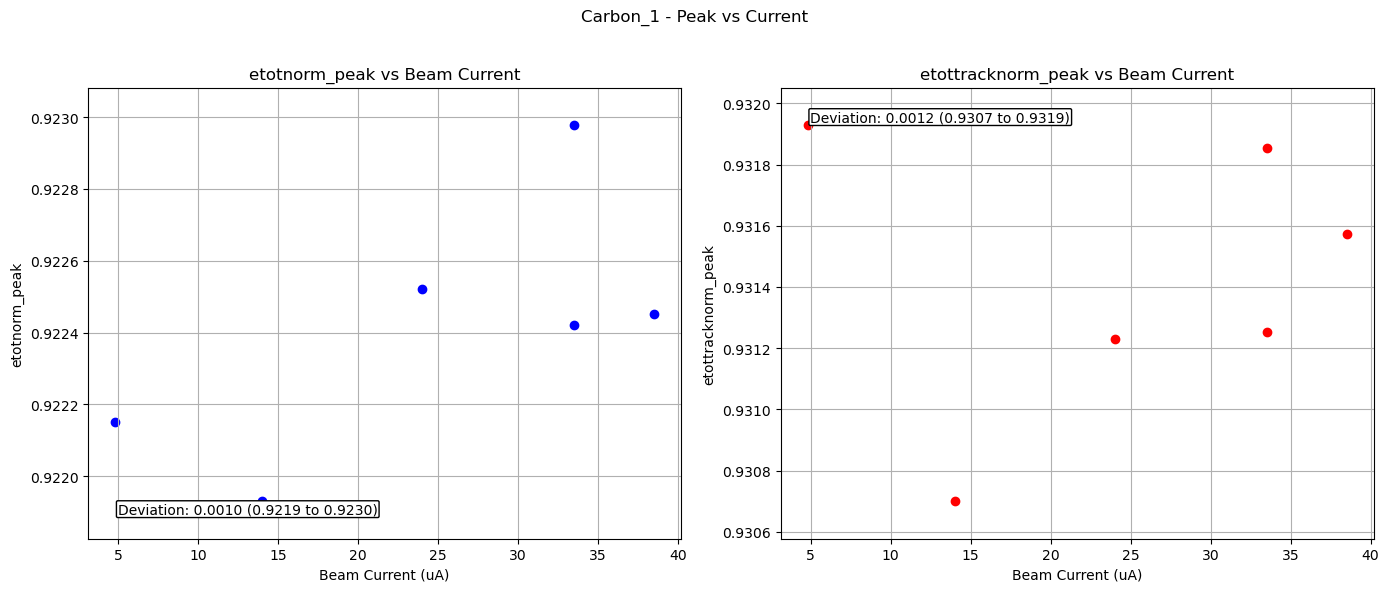

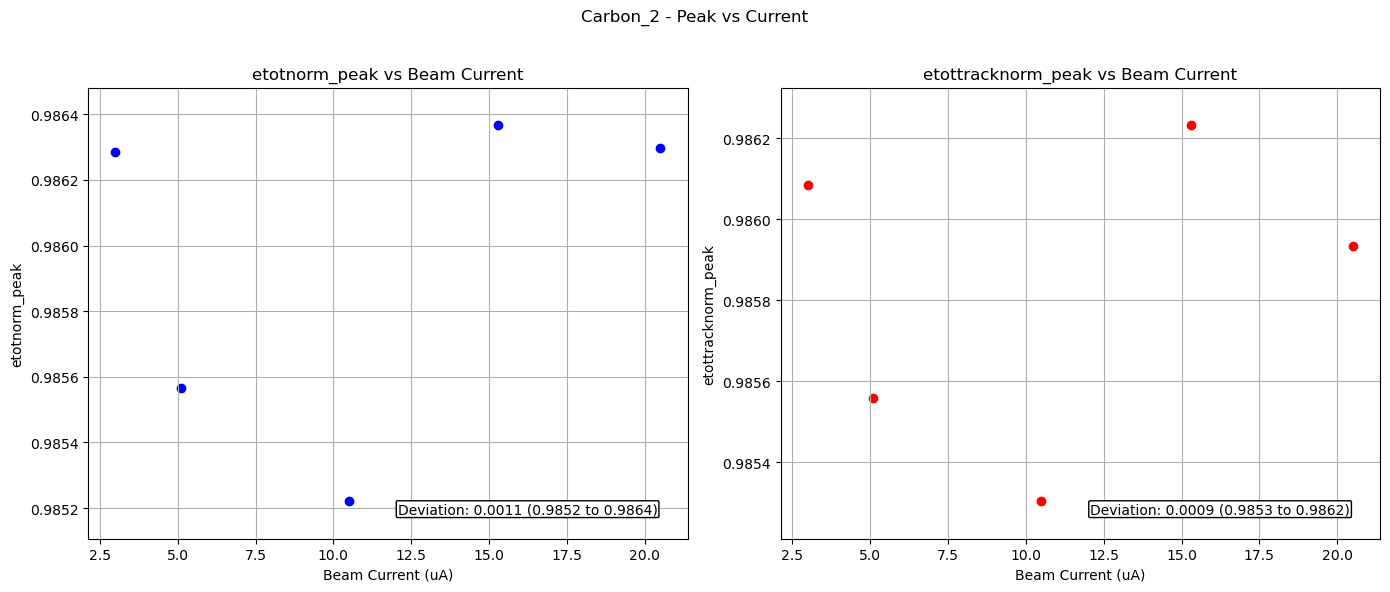

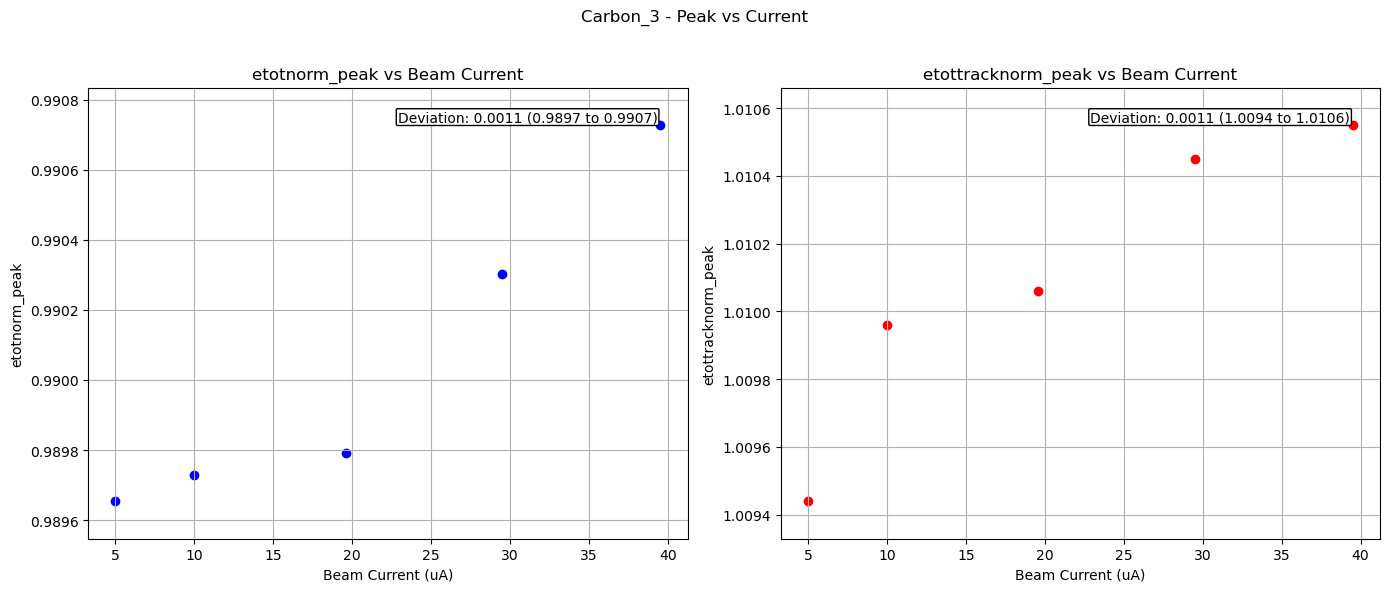

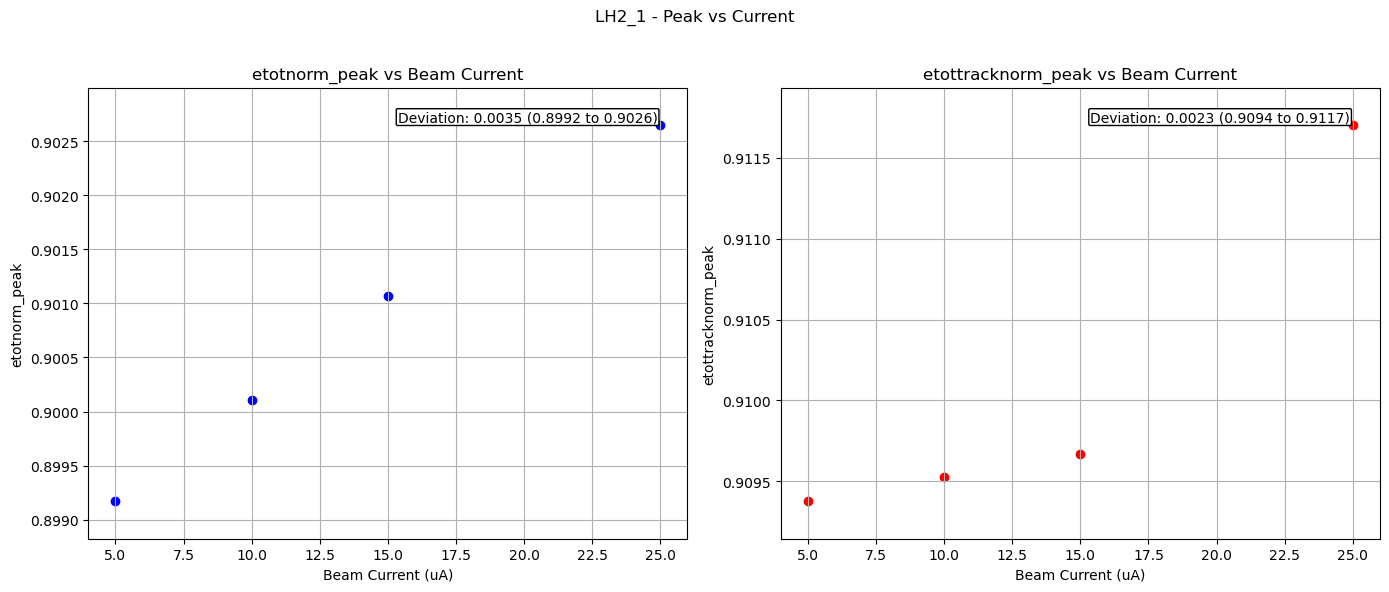

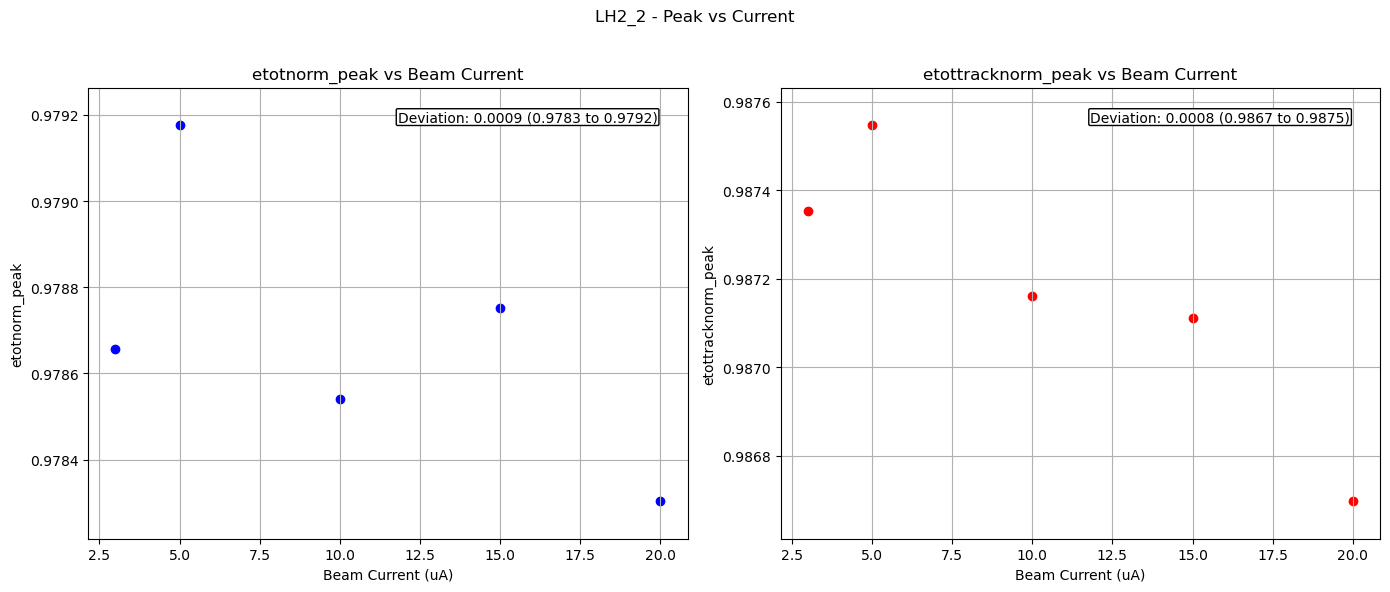

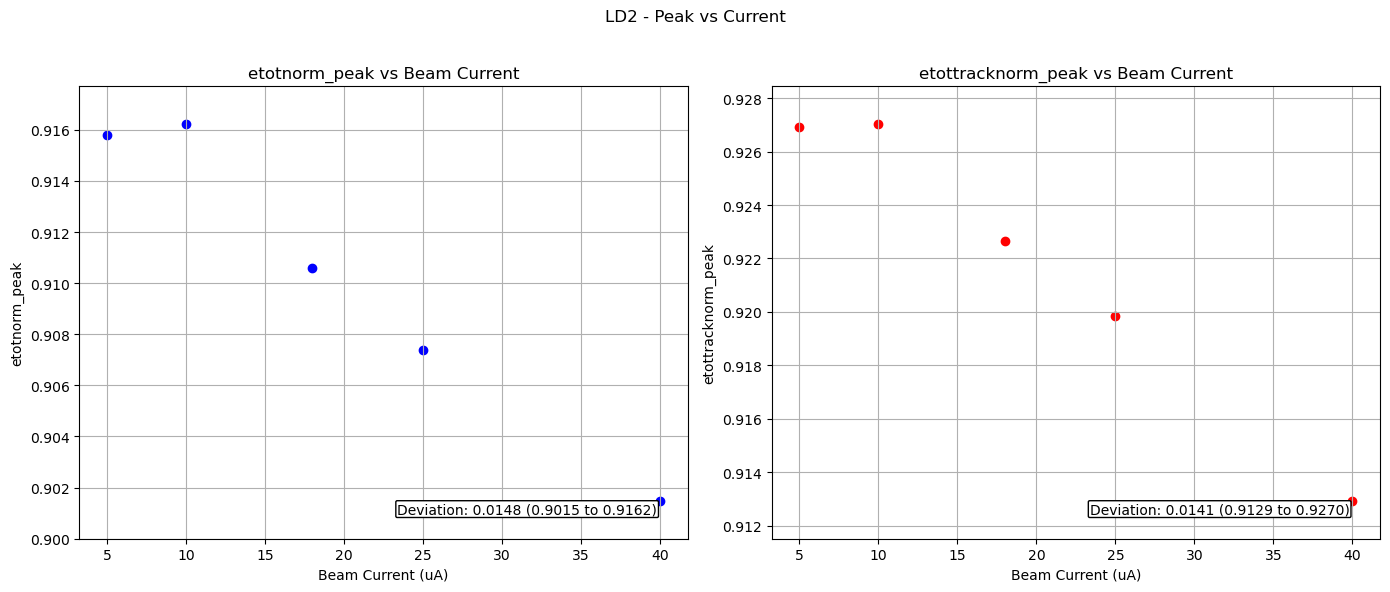

In [19]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt

# Define the datasets dictionary
datasets = {
    "Carbon_1": {
        "runs": [1523, 1524, 1525, 1526, 1528, 1530],
        "currents": [33.5, 33.5, 38.5, 24, 14, 4.8],
        "ps_factors": [9, 5, 5, 5, 3, 1]
    },
    "Carbon_2": {
        "runs": [6845, 6846, 6847, 6848, 6849],
        "currents": [5.1, 20.5, 15.3, 10.5, 3],
        "ps_factors": [1, 1, 1, 1, 1]
    },
    "Carbon_3": {
        "runs": [7003, 7004, 7005, 7006, 7007],
        "currents": [39.5, 29.5, 19.6, 10, 5],
        "ps_factors": [1, 1, 1, 1, 1]
    },
    "LH2_1": {
        "runs": [1514, 1515, 1516, 1517],
        "currents": [5, 10, 15, 25],
        "ps_factors": [1, 3, 5, 9]
    },
    "LH2_2": {
        "runs": [6850, 6851, 6852, 6853, 6854],
        "currents": [5, 20, 15, 10, 3],
        "ps_factors": [1, 1, 1, 1, 1]
    },
    "LD2": {
        "runs": [1518, 1519, 1520, 1521, 1522],
        "currents": [40, 25, 18, 10, 5],
        "ps_factors": [65, 33, 33, 17, 9]
    }
}

# Read the CSV file with the peak data
csv_file = "/w/hallc-scshelf2102/nps/singhav/nps_analysis/luminosity_analysis/cal_peak_vs_current_cpp.csv"
df = pd.read_csv(csv_file)

def smart_text_position(values, xvals):
    # Decide text position based on value distribution
    if np.median(values) > np.mean(values):
        valign = 'bottom'
        yloc = 0.05  # lower y
    else:
        valign = 'top'
        yloc = 0.95  # upper y

    if np.median(xvals) > np.mean(xvals):
        halign = 'left'
        xloc = 0.05
    else:
        halign = 'right'
        xloc = 0.95

    return xloc, yloc, halign, valign

def plot_dataset(dataset_name, runs, currents, ps_factors, df):
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))
    fig.suptitle(f'{dataset_name} - Peak vs Current')

    data = df[df['run'].isin(runs)]
    etotnorm_peaks = data['etotnorm_peak'].values
    etottracknorm_peaks = data['etottracknorm_peak'].values

    def get_padded_limits(values, padding=0.1):
        vmin, vmax = values.min(), values.max()
        delta = (vmax - vmin) * padding if vmax != vmin else 1.0
        return vmin - delta, vmax + delta

    ylims_norm = get_padded_limits(etotnorm_peaks)
    ylims_track = get_padded_limits(etottracknorm_peaks)

    axs[0].scatter(currents, etotnorm_peaks, color='blue')
    axs[0].set_title('etotnorm_peak vs Beam Current')
    axs[0].set_xlabel('Beam Current (uA)')
    axs[0].set_ylabel('etotnorm_peak')
    axs[0].set_ylim(ylims_norm)
    axs[0].grid(True)

    axs[1].scatter(currents, etottracknorm_peaks, color='red')
    axs[1].set_title('etottracknorm_peak vs Beam Current')
    axs[1].set_xlabel('Beam Current (uA)')
    axs[1].set_ylabel('etottracknorm_peak')
    axs[1].set_ylim(ylims_track)
    axs[1].grid(True)

    dev_norm = f"Deviation: {etotnorm_peaks.max() - etotnorm_peaks.min():.4f} ({etotnorm_peaks.min():.4f} to {etotnorm_peaks.max():.4f})"
    dev_track = f"Deviation: {etottracknorm_peaks.max() - etottracknorm_peaks.min():.4f} ({etottracknorm_peaks.min():.4f} to {etottracknorm_peaks.max():.4f})"

    x0, y0, ha0, va0 = smart_text_position(etotnorm_peaks, currents)
    x1, y1, ha1, va1 = smart_text_position(etottracknorm_peaks, currents)

    axs[0].text(x0, y0, dev_norm, transform=axs[0].transAxes,
                fontsize=10, verticalalignment=va0, horizontalalignment=ha0,
                bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.1'))

    axs[1].text(x1, y1, dev_track, transform=axs[1].transAxes,
                fontsize=10, verticalalignment=va1, horizontalalignment=ha1,
                bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.1'))

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# Plot for each dataset in the dictionary
for dataset_name, data in datasets.items():
    plot_dataset(dataset_name, data['runs'], data['currents'], data['ps_factors'], df)
